# RFM Analysis

This iPython notebook explains how to perform RFM analysis from customer purchase history data. The sample orders file is Sample - Superstore dataset from Tableau Software.

If you have suggestions or improvements please contribute on https://github.com/joaolcorreia/RFM-analysis

In [327]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


Read the sample orders file, containing all past purchases for all customers.

In [328]:
orders = pd.read_csv('sample-orders.csv',encoding='ISO-8859-1')

In [329]:
orders.head()

,order_date,order_id,customer,grand_total
0,9/7/2011,CA-2011-100006,Dennis Kane,378
1,7/8/2011,CA-2011-100090,Ed Braxton,699
2,3/14/2011,CA-2011-100293,Neil Franzsisch,91
3,1/29/2011,CA-2011-100328,Jasper Cacioppo,4
4,4/8/2011,CA-2011-100363,Jim Mitchum,21


## Create the RFM Table

Since recency is calculated for a point in time and the Tableau Super Store dataset last order date is Dec 31 2014, that is the date we will use to calculate recency.

Set this date to the current day and extract all orders until yesterday.

In [350]:
import datetime as dt
#NOW = dt.datetime(2011,12,31).date()
NOW = dt.datetime(2014,12,31)
print(type(NOW))

<class 'datetime.datetime'>


In [351]:
# Make the date_placed column datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])
#orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate']).dt.date
print(type(orders['order_date'][0]))

<class 'pandas._libs.tslib.Timestamp'>


Create the RFM Table

In [353]:
rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (NOW - x.max()).days, # Recency
                                        'order_id': lambda x: len(x),      # Frequency
                                        'grand_total': lambda x: x.sum()}) # Monetary Value

# rfmTable = orders.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, # Recency
#                                         'InvoiceNo': lambda x: len(x),      # Frequency
#                                         'GrandTotal': lambda x: x.sum()}) # Monetary Value

#rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)

rfmTable['order_date'] = rfmTable['order_date'].astype(int)
# rfmTable.rename(columns={'InvoiceDate': 'recency', 
#                          'InvoiceNo': 'frequency', 
#                          'GrandTotal': 'monetary_value'}, inplace=True)
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)


## Validating the RFM Table

In [354]:
rfmTable.head()

,recency,monetary_value,frequency
customer,,,
Aaron Bergman,415,887,3
Aaron Hawkins,12,1744,7
Aaron Smayling,88,3050,7
Adam Bellavance,54,7756,8
Adam Hart,34,3249,10


Customer **Aaron Bergman** has frequency:3, monetary value:$887 and recency:415 days.

In [355]:
aaron = orders[orders['customer']=='Aaron Bergman']
aaron

,order_date,order_id,customer,grand_total
624,2011-02-19,CA-2011-152905,Aaron Bergman,13
665,2011-03-07,CA-2011-156587,Aaron Bergman,310
2336,2013-11-11,CA-2013-140935,Aaron Bergman,564


Inserting the date of Aaron purchase and comparing it to the recency in the rfmTable we verify our RFM table is correct.

In [356]:
(NOW - dt.datetime(2013,11,11)).days==415

True

## Determining RFM Quartiles

In [357]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [358]:
quantiles

,recency,monetary_value,frequency
0.25,30.0,1139.75,5.0
0.50,75.5,2255.50,6.0
0.75,183.0,3779.50,8.0


Send quantiles to a dictionary, easier to use.

In [359]:
quantiles = quantiles.to_dict()

In [360]:
quantiles

{'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1139.75, 0.5: 2255.5, 0.75: 3779.5},
 'recency': {0.25: 30.0, 0.5: 75.5, 0.75: 183.0}}

## Creating the RFM segmentation table

In [361]:
rfmSegmentation = rfmTable

We create two classes for the RFM segmentation since, being high recency is bad, while high frequency and monetary value is good. 

In [362]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [363]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [364]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [365]:
rfmSegmentation.head()

,recency,monetary_value,frequency,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,887,3,4,4,4,444
Aaron Hawkins,12,1744,7,1,2,3,123
Aaron Smayling,88,3050,7,3,2,2,322
Adam Bellavance,54,7756,8,2,2,1,221
Adam Hart,34,3249,10,2,1,2,212


In [366]:
# Uncomment any of the following lines to: copy data to clipboard or save it to a CSV file.
# rfmSegmentation.to_clipboard()
# rfmSegmentation.to_csv('rfm-table.csv', sep=',')

Who are the top 5 best customers? by RFM Class (111), high spenders who buy recently and frequently?

In [367]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111'].sort_values('monetary_value', ascending=False).head(5)
rfmSegmentation['CustomerID'] = Series(rfmSegmentation.index.get_values(), index=rfmSegmentation.index)
print(rfmSegmentation)

                      recency  monetary_value  frequency  R_Quartile  \
customer                                                               
Aaron Bergman             415             887          3           4   
Aaron Hawkins              12            1744          7           1   
Aaron Smayling             88            3050          7           3   
Adam Bellavance            54            7756          8           2   
Adam Hart                  34            3249         10           2   
Adam Shillingsburg         28            3256          9           1   
Adrian Barton              41           14474         10           2   
Adrian Hane                60            1734          7           2   
Adrian Shami               41              59          2           2   
Aimee Bixby                41             968          5           2   
Alan Barnes                25            1114          8           1   
Alan Dominguez             29            6107          8        

In [368]:
from pandas import Series, DataFrame
customerSegmentation = rfmSegmentation.groupby('RFMClass').agg({'RFMClass': lambda x: len(x),'monetary_value':lambda x: sum(x)  }) 
customerSegmentation.rename(columns={'RFMClass': 'ClassName','monetary_value':'MonetaryValue'}, inplace=True)
print(customerSegmentation.index.get_values())
print(customerSegmentation.values[0])
customerSegmentation['RFMClass'] = Series(customerSegmentation.index.get_values(), index=customerSegmentation.index)
print((customerSegmentation))

['111' '112' '113' '114' '121' '122' '123' '124' '131' '132' '133' '134'
 '141' '142' '143' '144' '211' '212' '213' '221' '222' '223' '224' '231'
 '232' '233' '234' '241' '242' '243' '244' '311' '312' '313' '314' '321'
 '322' '323' '324' '331' '332' '333' '334' '341' '342' '343' '344' '411'
 '412' '413' '421' '422' '423' '424' '431' '432' '433' '434' '441' '442'
 '443' '444']
[178453     30]
          MonetaryValue  ClassName RFMClass
RFMClass                                   
111              178453         30      111
112               60790         21      112
113               10324          6      113
114                1057          1      114
121              116577         22      121
122               48503         17      122
123               36432         21      123
124                4922          5      124
131               31575          5      131
132               25020          9      132
133               13121          8      133
134                1993          

62


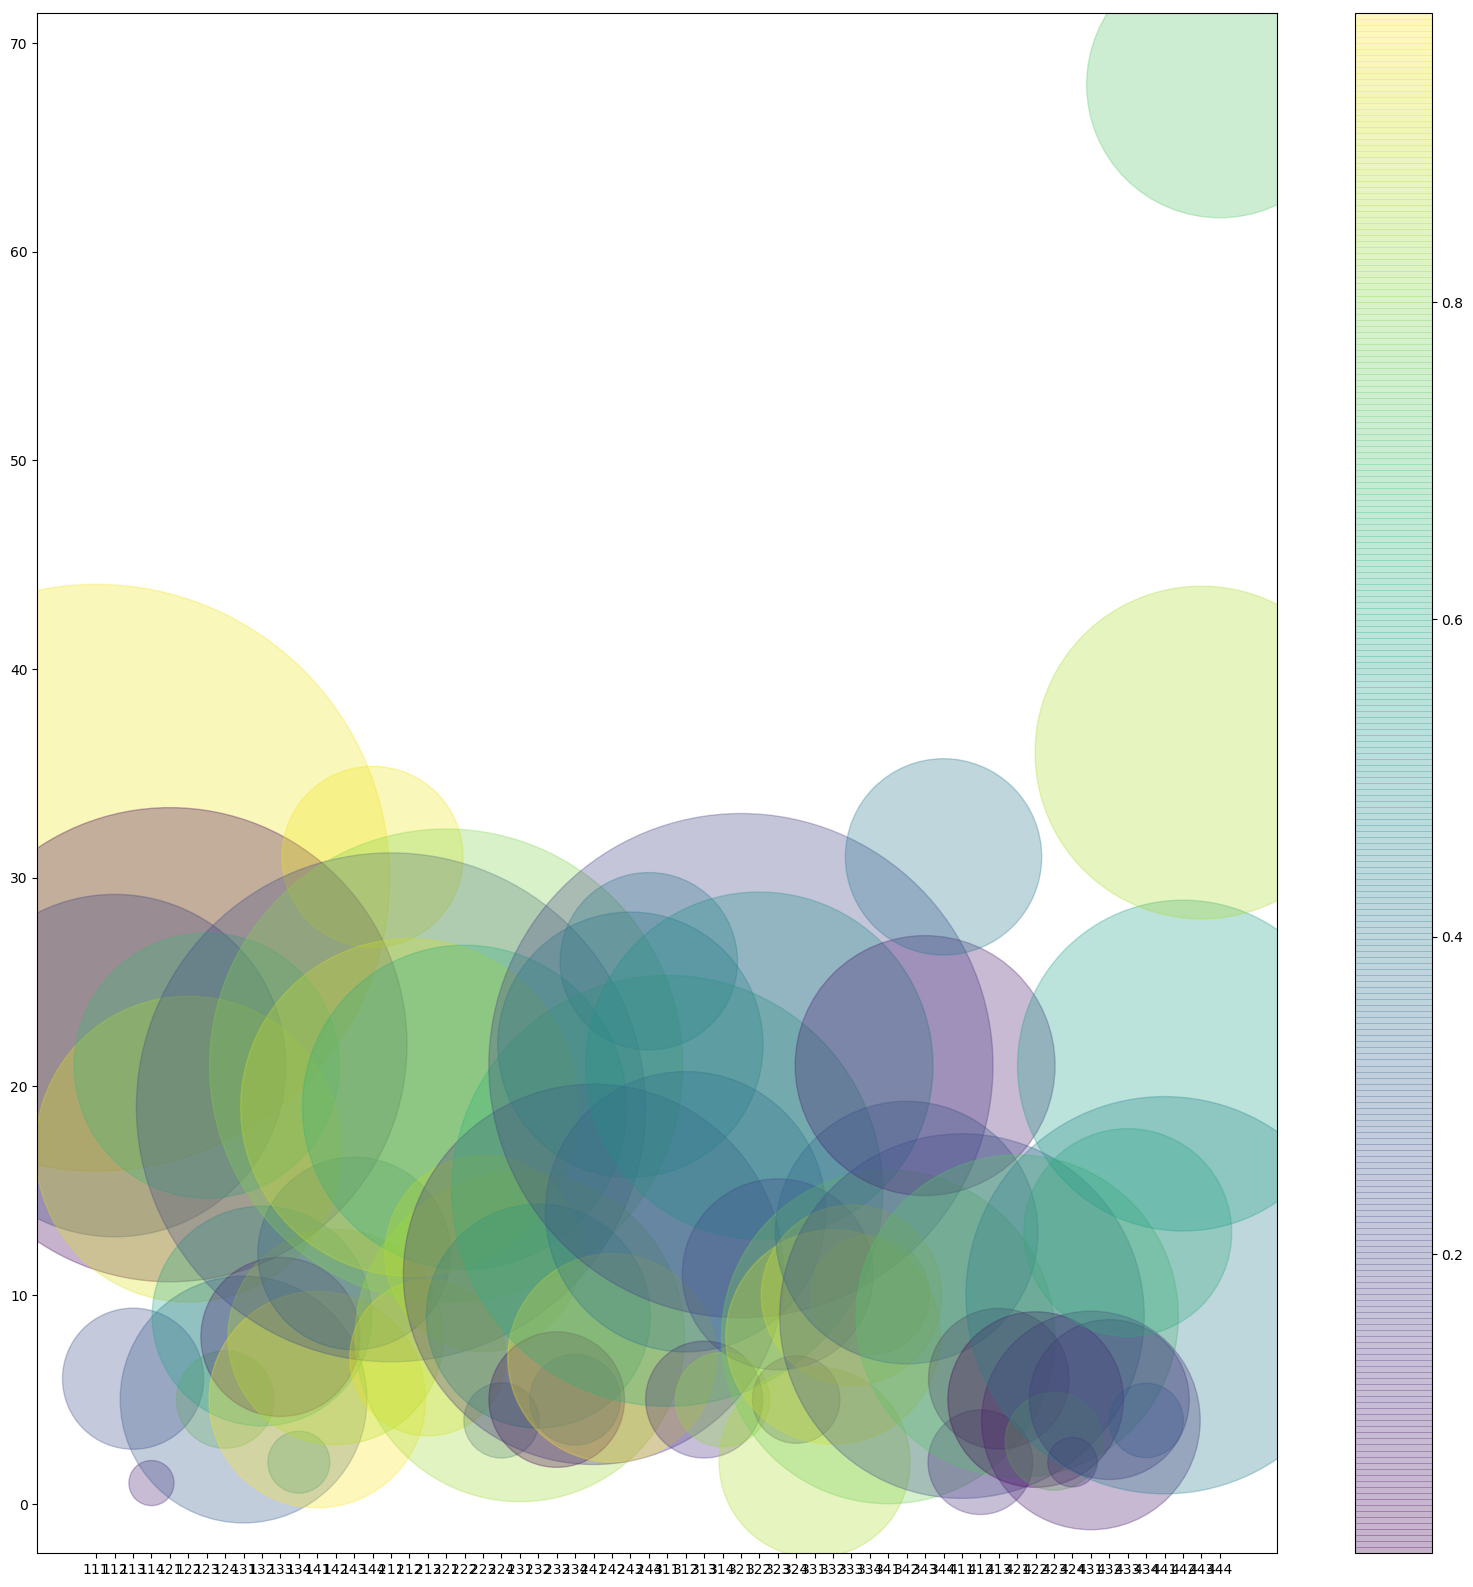

In [369]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.RandomState(0)
x = rng.randn(100)
y = rng.randn(100)
colors = rng.rand(62)
sizes = 1000 * rng.rand(100)
print(len(customerSegmentation['RFMClass'].values))
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 20
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size
plt.scatter(customerSegmentation['RFMClass'].values,customerSegmentation['ClassName'].values, c=colors, s=customerSegmentation['MonetaryValue'].values, alpha=0.3,
            cmap='viridis')
plt.colorbar();  # show color scale

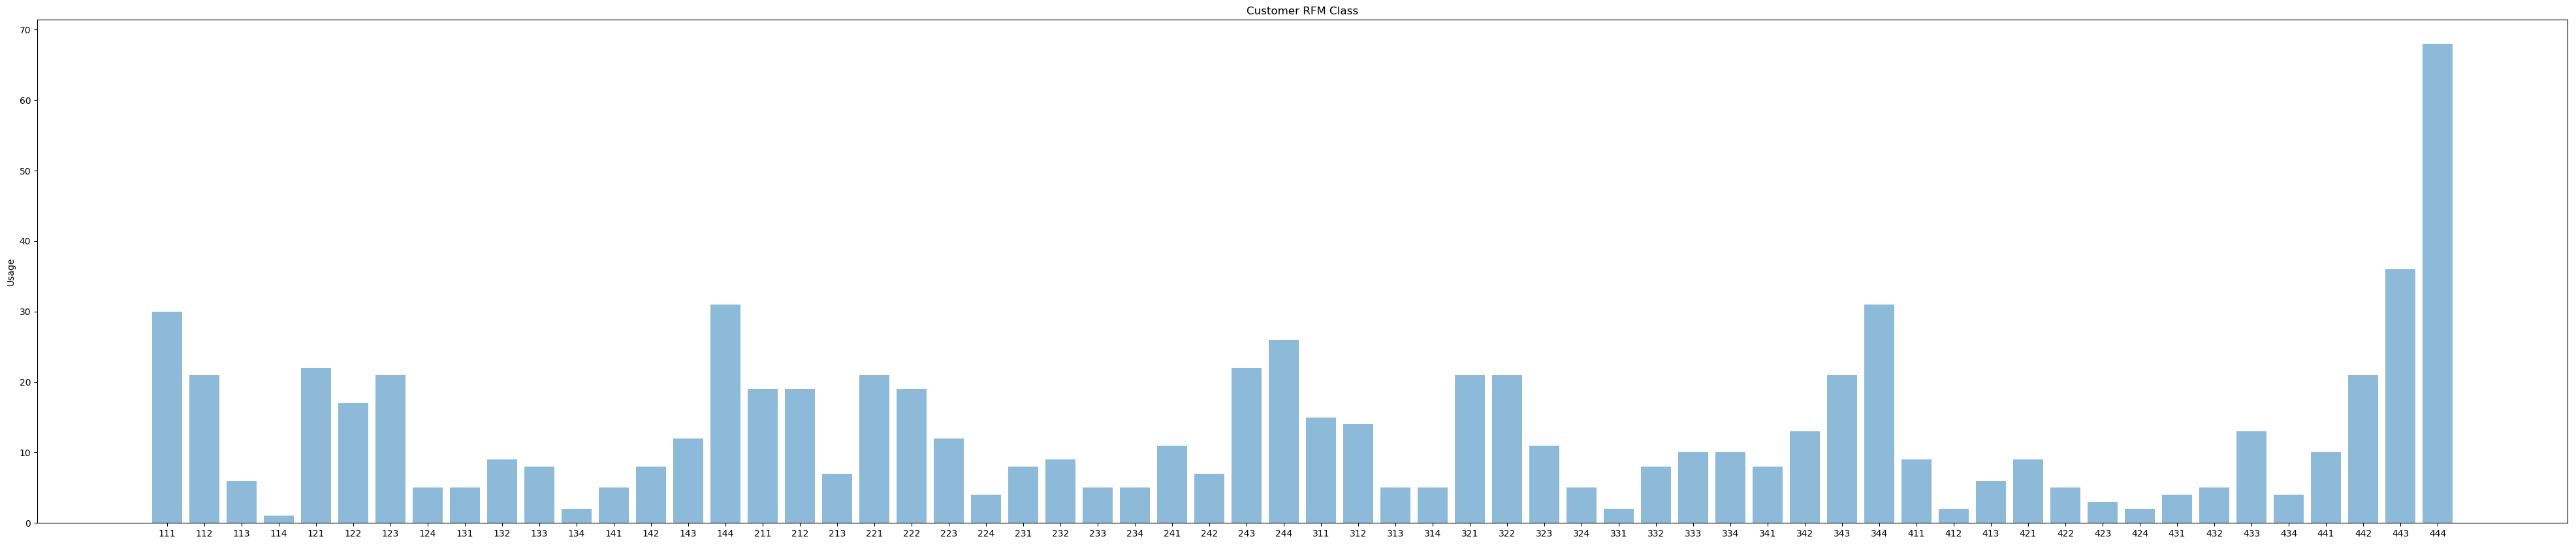

In [370]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(customerSegmentation['RFMClass'].index))
#print(y_pos)
performance = [10,8,6,4,2,1]
#print(np.arange(len(customerSegmentation['RFMClass'].index)))
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 50
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.bar(y_pos, customerSegmentation['ClassName'].values, align='center', alpha=0.5)
plt.xticks(y_pos, customerSegmentation['RFMClass'].index)
plt.ylabel('Usage')
plt.title('Customer RFM Class')

plt.show()

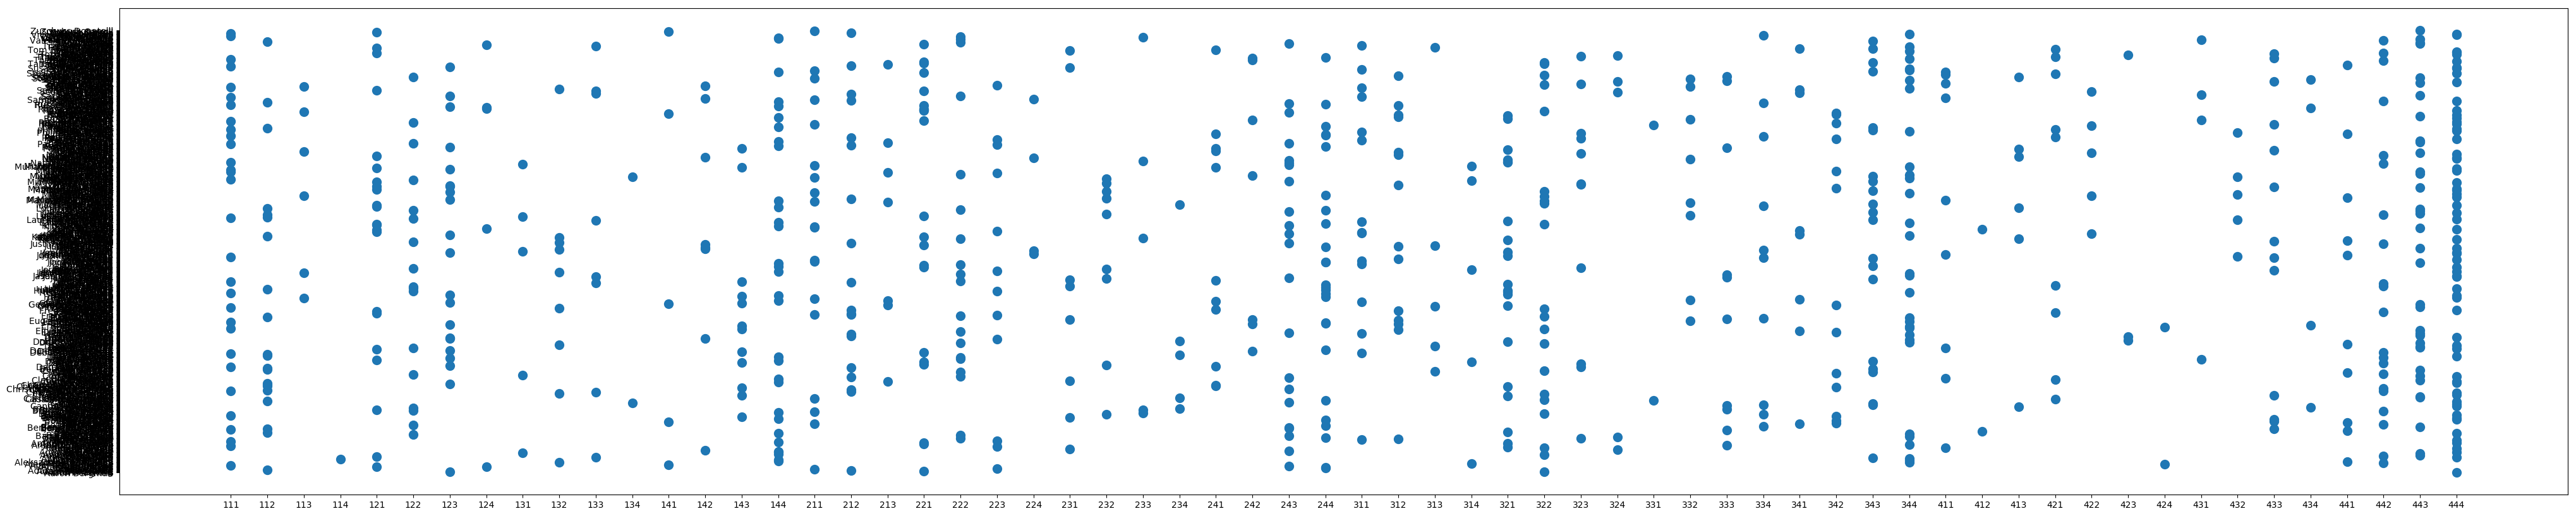

In [372]:
plt.scatter(rfmSegmentation['RFMClass'].values, rfmSegmentation['CustomerID'].values, s=100);

In [396]:
from sklearn.cluster import KMeans
import numpy as np
import csv

print(type(rfmTable))
print(rfmTable.columns)
print(rfmTable['recency'][0])
KMeanTable = [[]]
for i in range(len(rfmTable)):
    kMeanLine = []
    kMeanLine.append(rfmTable['recency'][i])
    kMeanLine.append(rfmTable['monetary_value'][i])
    kMeanLine.append(rfmTable['frequency'][i])
    KMeanTable.append(kMeanLine)

KMeanTable.pop(0)
print(KMeanTable[0])

kmeans = KMeans(n_clusters=7, random_state=0).fit(KMeanTable)
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)
line = [["Recency","monetary_value","frequency","RFMClass","CustomerName"]] 

for i in range(len(kmeans.labels_)):
    KMeanTable[i].append(kmeans.labels_[i])
    KMeanTable[i].append(rfmTable['CustomerID'][i])
    print(KMeanTable[i])
    line.append(KMeanTable[i])

with open('kmeans.csv', 'w',newline='',encoding="utf-8") as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in line:
        writer.writerow(row)

f.close()    

    

<class 'pandas.core.frame.DataFrame'>
Index(['recency', 'monetary_value', 'frequency', 'R_Quartile', 'F_Quartile',
       'M_Quartile', 'RFMClass', 'CustomerID'],
      dtype='object')
415
[415, 887, 3]
[415, 887, 3, 4, 'Aaron Bergman']
[12, 1744, 7, 0, 'Aaron Hawkins']
[88, 3050, 7, 5, 'Aaron Smayling']
[54, 7756, 8, 1, 'Adam Bellavance']
[34, 3249, 10, 5, 'Adam Hart']
[28, 3256, 9, 5, 'Adam Shillingsburg']
[41, 14474, 10, 2, 'Adrian Barton']
[60, 1734, 7, 0, 'Adrian Hane']
[41, 59, 2, 4, 'Adrian Shami']
[41, 968, 5, 4, 'Aimee Bixby']
[25, 1114, 8, 4, 'Alan Barnes']
[29, 6107, 8, 3, 'Alan Dominguez']
[55, 1587, 4, 0, 'Alan Haines']
[6, 4806, 9, 3, 'Alan Hwang']
[22, 4261, 5, 3, 'Alan Schoenberger']
[192, 585, 7, 4, 'Alan Shonely']
[166, 914, 9, 4, 'Alejandro Ballentine']
[278, 2584, 5, 5, 'Alejandro Grove']
[19, 3214, 6, 5, 'Alejandro Savely']
[118, 368, 4, 4, 'Aleksandra Gannaway']
[184, 5564, 5, 3, 'Alex Avila']
[8, 662, 5, 4, 'Alex Grayson']
[111, 1056, 4, 4, 'Alex Russell']
[28, 8

In [373]:
'''
K-Means Clustering Algorithm
Implementation With Kaggle Dataset
By S.M. Akash
7/31/2018

'''

from sklearn.cluster import KMeans
import numpy as np
import csv

print((rfmTable.values[0:3]))
kmeans = KMeans(n_clusters=7, random_state=0).fit(rfmTable.values)
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)

print(len(rfmTable))
line = [["Customer_id","monetary_value","frequency","recency","RFMClass"]]    
for i in range (len(kmeans.labels_)):
    #print(str(rfmTable.values[i][0])+ '->'+str(rfmTable.values[i][1]) +'->' + str(rfmTable.values[i][2])+'->'+ str(kmeans.labels_[i]))
    row = []
    row.append(rfmTable.values[i][7])
    row.append(rfmTable.values[i][0])
    row.append(rfmTable.values[i][1])
    row.append(rfmTable.values[i][2])
    row.append(kmeans.labels_[i])
    line.append(row)

with open('kmeans.csv', 'w',newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in line:
        writer.writerow(row)

f.close()

[[415 887 3 4 4 4 '444' 'Aaron Bergman']
 [12 1744 7 1 2 3 '123' 'Aaron Hawkins']
 [88 3050 7 3 2 2 '322' 'Aaron Smayling']]


ValueError: could not convert string to float: 'Zuschuss Donatelli'

In [448]:
print(rfmTable.columns)
AggloTable=[[]]
CustomerName = []
for i in range(len(rfmTable.values)):
    line = []
    line.append(rfmTable.values[i][0])
    line.append(rfmTable.values[i][1])
    line.append(rfmTable.values[i][2])
    CustomerName.append(rfmTable.values[i][7])
    AggloTable.append(line)
AggloTable.pop(0)
print(CustomerName[0])

Index(['recency', 'monetary_value', 'frequency', 'R_Quartile', 'F_Quartile',
       'M_Quartile', 'RFMClass', 'CustomerID'],
      dtype='object')
Aaron Bergman


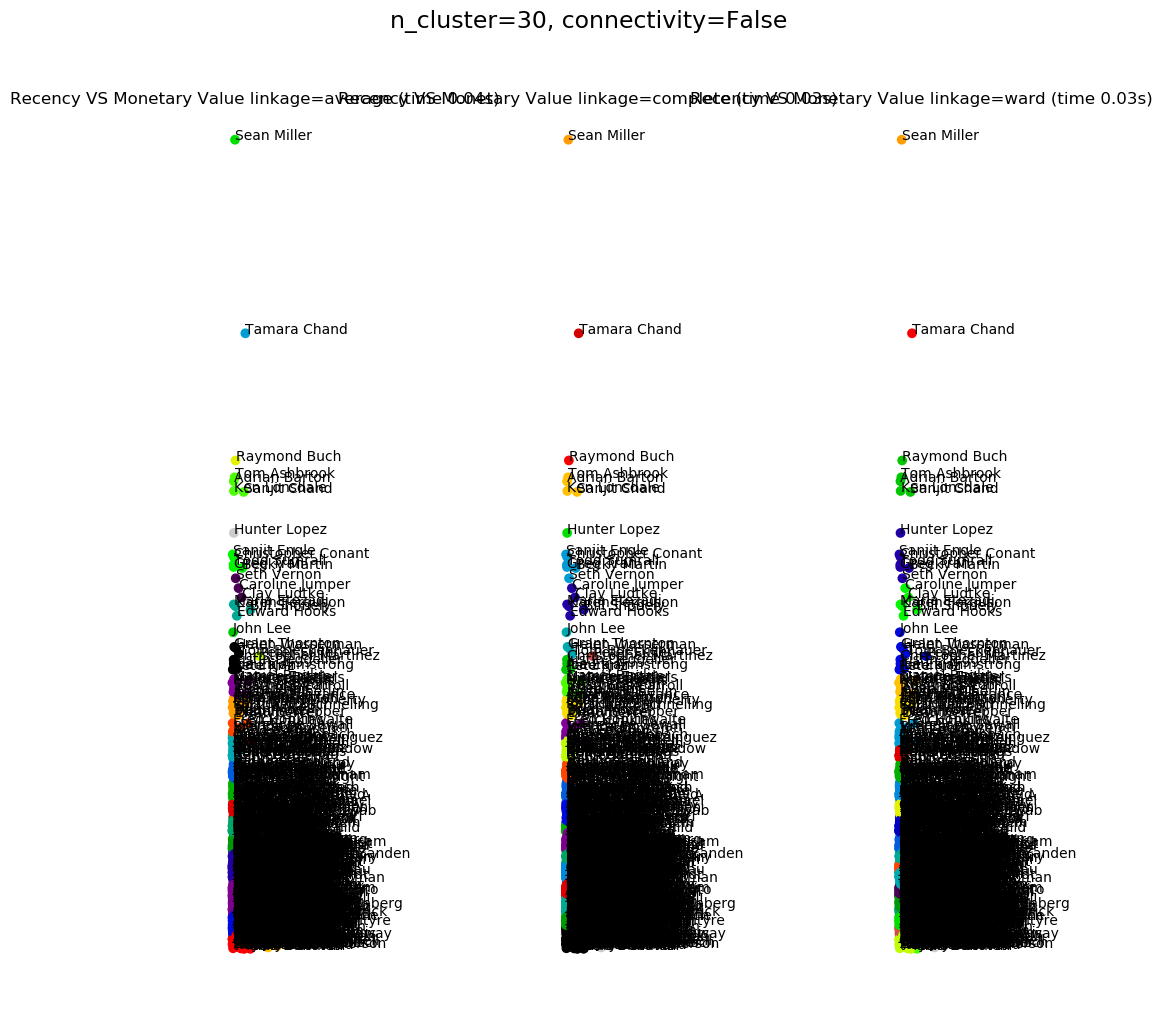

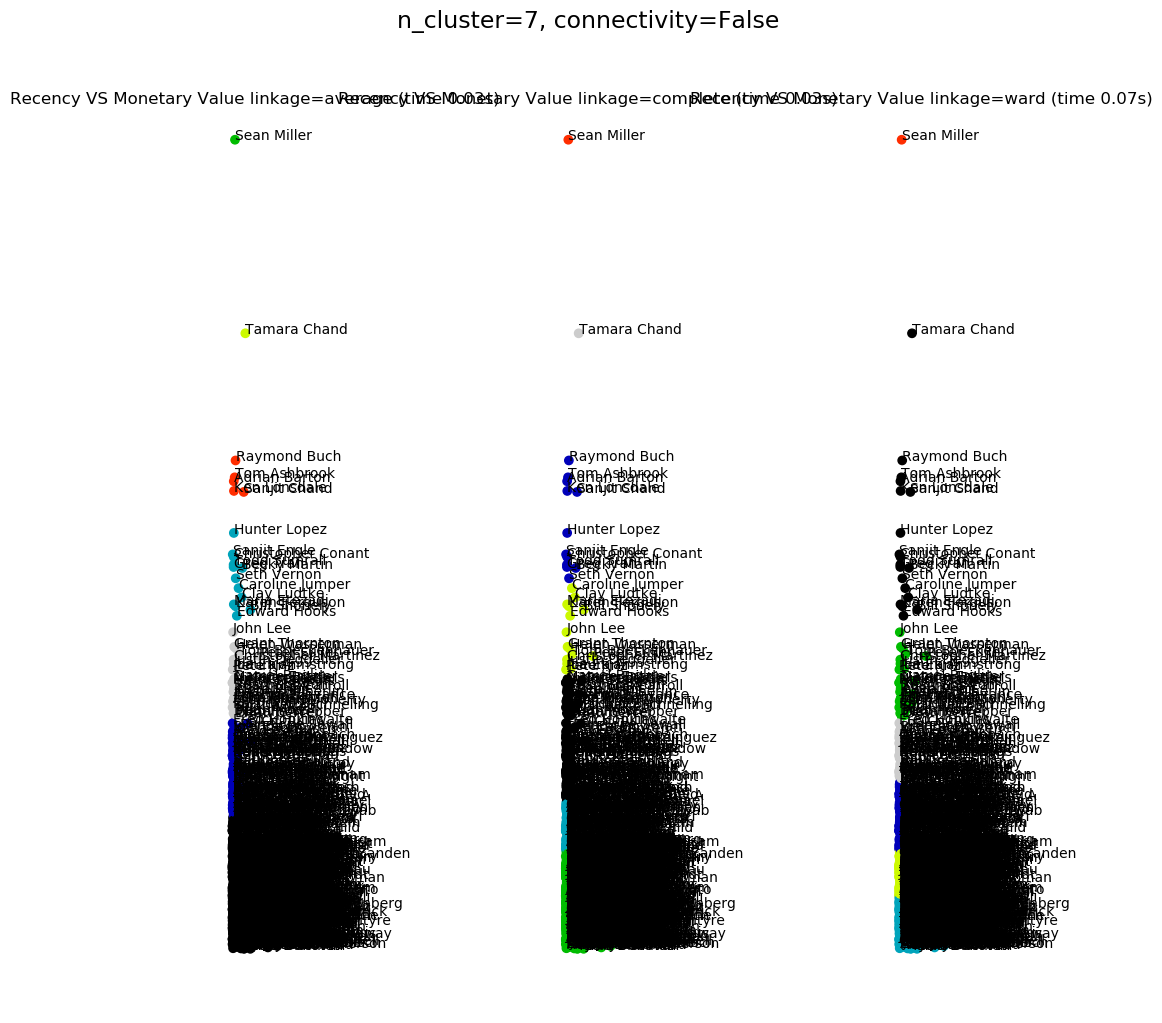

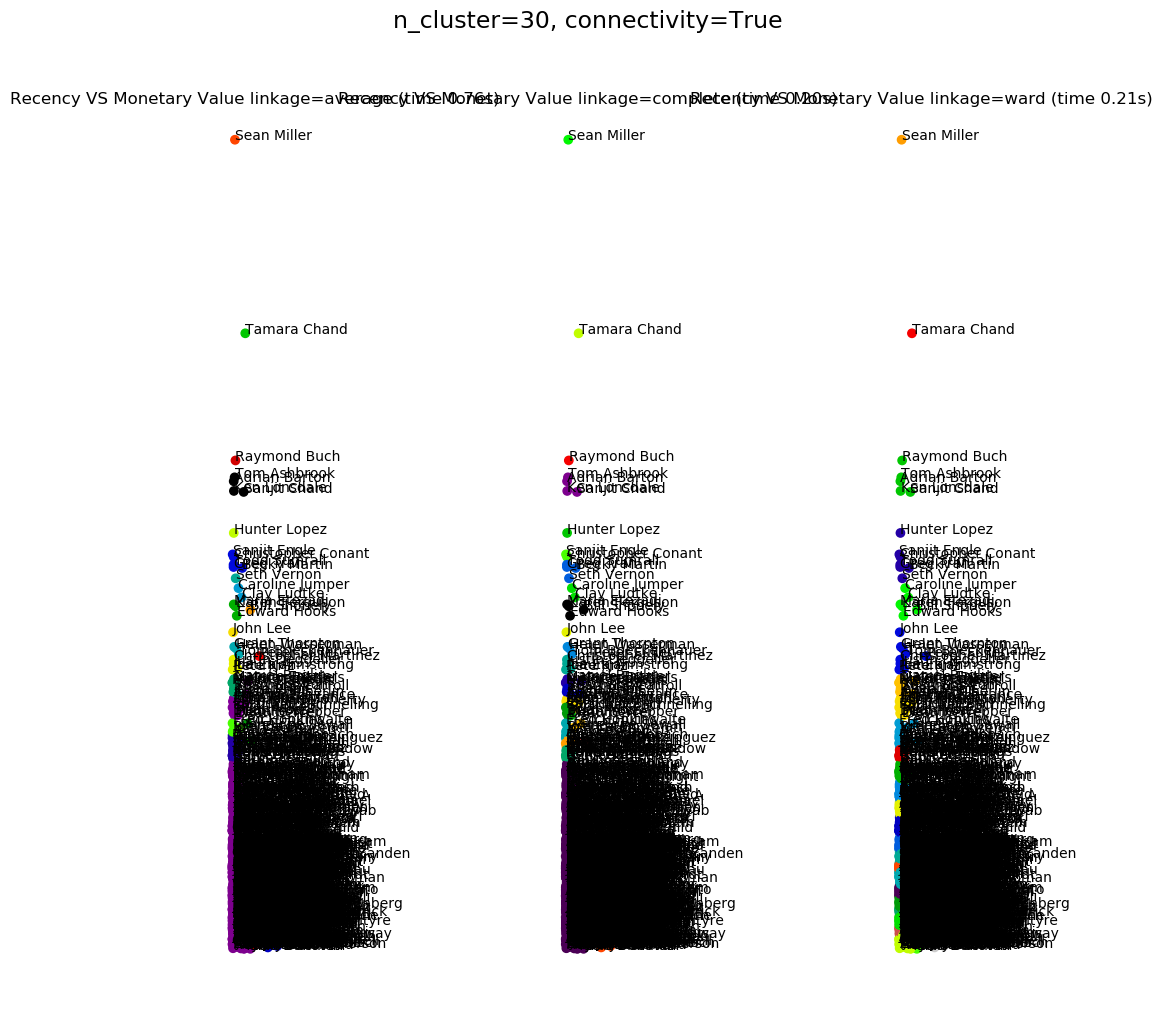

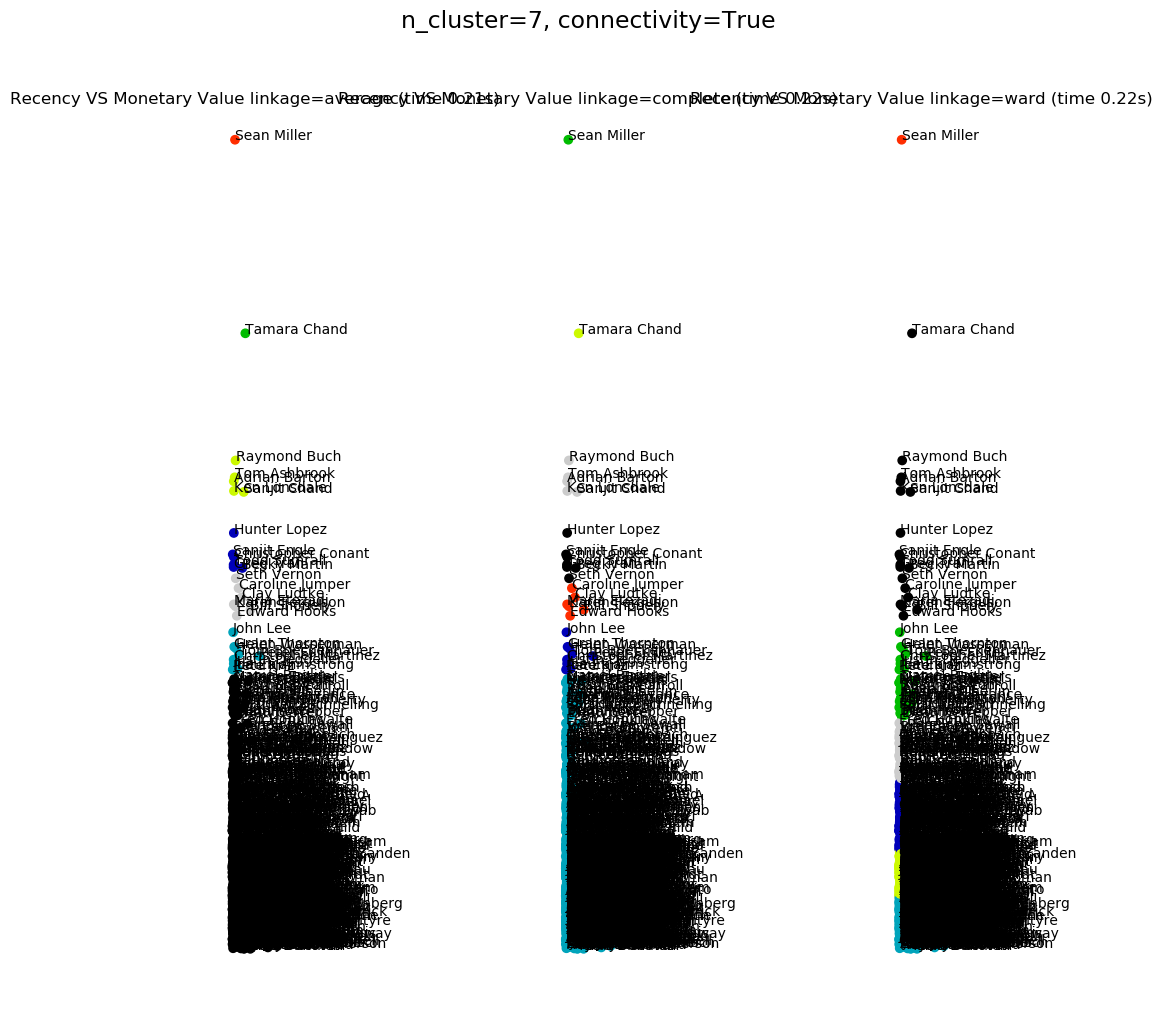

In [433]:
# Authors: Gael Varoquaux, Nelle Varoquaux
# License: BSD 3 clause

import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T


# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(AggloTable, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 7):
        plt.figure(figsize=(10, 10))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            #model.fit(X)
            ResultAgglo = model.fit(AggloTable)
            elapsed_time = time.time() - t0
            #plt.scatter(X[:, 0], X[:, 1], c=model.labels_,cmap=plt.cm.nipy_spectral)
            plt.scatter([i[0] for i in AggloTable], [i[1] for i in AggloTable], c=model.labels_,cmap=plt.cm.nipy_spectral)
            plt.title('Recency VS Monetary Value linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            z = [i[0] for i in AggloTable]
            y = [i[1] for i in AggloTable]
            
            for i, txt in enumerate(CustomerName):
                plt.annotate(txt, (z[i], y[i]))
                
            
             
            plt.axis('equal')
            plt.axis('off')
            plt.xlabel(str())
            plt.ylabel("y-label")
            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

In [434]:
print(AggloTable[0])
print(X)
print(X[:,0])
print(ResultAgglo.labels_)

[415, 887, 3]
[[13.26942176 -2.5793499 ]
 [-9.52436093 10.39179655]
 [10.37103658  8.4106398 ]
 ...
 [ 6.28494345 -0.25755083]
 [ 3.73669373 -3.71119963]
 [-1.22031564  8.24154775]]
[13.26942176 -9.52436093 10.37103658 ...  6.28494345  3.73669373
 -1.22031564]
[2 4 1 3 1 1 0 4 2 2 2 6 2 1 1 2 2 4 1 2 6 2 2 2 2 2 4 2 2 6 4 4 4 2 2 6 2
 2 2 2 4 2 1 2 1 3 6 4 1 4 2 1 1 2 1 2 1 4 2 1 1 4 4 2 2 2 2 4 4 2 2 2 4 1
 4 0 4 6 1 4 2 2 4 2 2 4 4 6 1 4 0 1 4 4 2 2 4 2 2 1 2 4 6 2 2 4 1 2 2 3 1
 1 4 6 2 2 4 2 2 2 4 2 2 2 2 2 4 2 1 1 2 1 0 6 2 4 2 6 4 4 2 4 4 2 2 1 1 4
 4 4 2 4 2 4 6 1 0 3 1 4 4 2 2 4 2 6 2 1 2 0 4 4 4 2 2 6 4 4 4 1 2 4 2 1 4
 4 2 1 1 2 6 1 4 1 3 2 4 4 2 6 4 2 1 1 4 4 4 4 2 2 4 2 4 1 3 4 1 2 1 2 2 1
 2 1 6 4 4 2 2 1 6 1 4 2 2 1 2 2 2 4 1 2 2 2 4 1 4 2 1 0 4 2 4 4 1 2 4 1 4
 6 2 2 2 4 2 2 1 4 2 2 1 2 1 1 1 4 2 2 2 4 4 1 2 1 1 4 1 1 4 6 4 2 4 1 1 1
 1 2 2 1 2 4 2 1 4 4 6 3 4 2 1 6 0 2 2 2 2 2 2 4 6 2 3 2 1 4 4 3 2 1 2 4 2
 1 0 4 1 2 1 4 2 1 6 2 4 1 3 4 1 4 4 2 4 2 2 4 4 2 4 4 2 2 4 2 2

In [437]:
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)

print(len(rfmTable))
AgglomerateLine = [["Customer_id","monetary_value","frequency","recency","RFMClass"]]    
for i in range (len(kmeans.labels_)):
    #print(str(rfmTable.values[i][0])+ '->'+str(rfmTable.values[i][1]) +'->' + str(rfmTable.values[i][2])+'->'+ str(kmeans.labels_[i]))
    row = []
    row.append(rfmTable.values[i][7])
    row.append(rfmTable.values[i][0])
    row.append(rfmTable.values[i][1])
    row.append(rfmTable.values[i][2])
    row.append(ResultAgglo.labels_[i])
    AgglomerateLine.append(row)

with open('Agglomerative.csv', 'w',newline='',encoding='utf-8') as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in AgglomerateLine:
        writer.writerow(row)

f.close()

794


[-1  0  0 -1 -1  1 -1  0 -1  2  5 -1  3  1  2 -1 -1 -1  4  3 -1  2  3  2
 -1  2  2 -1  4 -1 -1 -1  5  2 -1 -1  3 -1  3  3  2  0 -1 -1  0 -1 -1  5
 -1  4  3  0 -1 -1 -1  3 -1  0 -1 -1 -1  0  0  6  0  2  3  5  5  2 -1  6
 -1 -1 -1 -1  4 -1  1 -1  3  2 -1  4  6  0 -1 -1 -1  2 -1  2 -1  2 -1 -1
 -1  3 -1 -1  2  2 -1 -1  4  4  0  4  6 -1 -1  0  4 -1  4  4  0 -1 -1 -1
  4  2 -1 -1  3  4  2 -1 -1  4  6  5 -1 -1  4 -1 -1 -1 -1  3 -1  0  4 -1
  4 -1 -1 -1 -1  1 -1 -1  3  2 -1 -1 -1 -1  1  5 -1 -1 -1  1 -1 -1 -1 -1
  6 -1  3 -1  0 -1 -1 -1  0 -1  2 -1  3  5  1  0 -1  1  6 -1  1  5 -1  2
  5  4 -1  0 -1  2 -1 -1  3  2  0 -1  0  5  0 -1 -1 -1  1  4 -1  1 -1 -1
 -1  2  2  5  3 -1 -1  5 -1 -1 -1 -1 -1  4 -1  5  5 -1  2  0  4 -1  2  0
 -1  0  0 -1 -1  1 -1 -1 -1 -1 -1  3  2  5  2 -1 -1  5  2 -1  2 -1  2  3
 -1  0  2 -1  2  3  1  3 -1 -1 -1  2  4  4 -1 -1  0  0  0 -1  1 -1  5 -1
 -1 -1 -1 -1  1 -1  0  4  1 -1 -1 -1 -1 -1 -1 -1  3  0 -1 -1  1 -1 -1 -1
 -1 -1 -1  3  2 -1  3  0 -1  2 -1  2 -1  0  5 -1  2

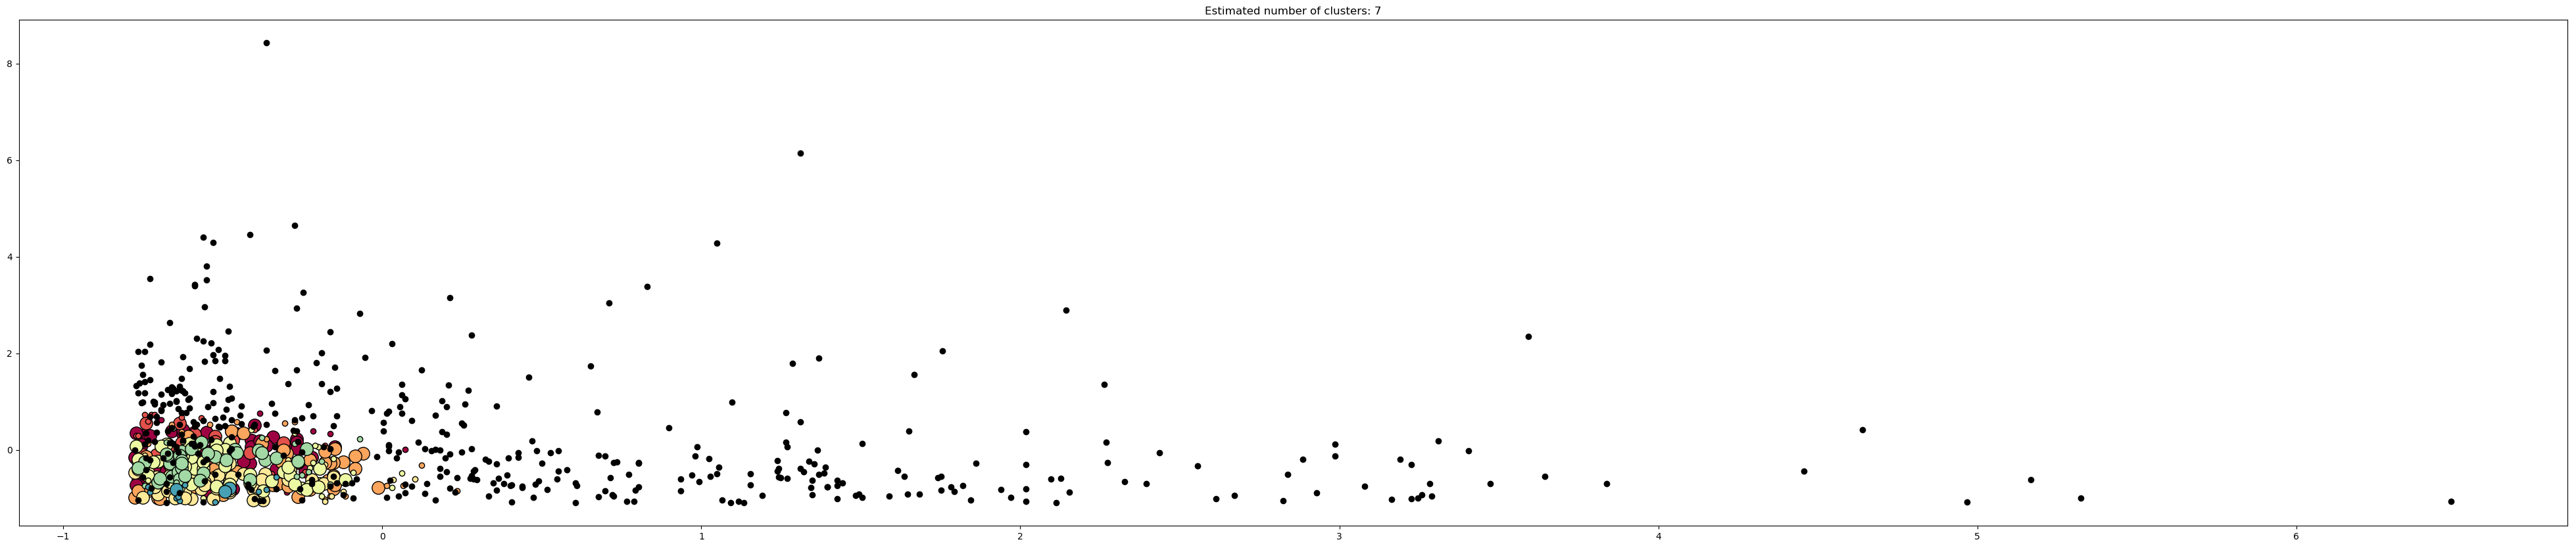

In [461]:
# ###############################
# DBSCAN(Density Based Spatial Clustering of Applications with Clustering) Algorithm

# ###############################
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=794, centers=centers, cluster_std=0.4,
                            random_state=0)
#print(AggloTable)
X = StandardScaler().fit_transform(AggloTable)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=12).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [458]:
csv.register_dialect('myDialect',quoting=csv.QUOTE_ALL,skipinitialspace=True)

print(len(rfmTable))
DBSCANLine = [["Customer_id","monetary_value","frequency","recency","RFMClass"]]    
for i in range (len(kmeans.labels_)):
    #print(str(rfmTable.values[i][0])+ '->'+str(rfmTable.values[i][1]) +'->' + str(rfmTable.values[i][2])+'->'+ str(kmeans.labels_[i]))
    row = []
    row.append(rfmTable.values[i][7])
    row.append(rfmTable.values[i][0])
    row.append(rfmTable.values[i][1])
    row.append(rfmTable.values[i][2])
    row.append(labels[i])
    DBSCANLine.append(row)

with open('DBSCAN.csv', 'w',newline='',encoding='utf-8') as f:
    writer = csv.writer(f, dialect='myDialect')
    for row in DBSCANLine:
        writer.writerow(row)

f.close()

794
